## 1. Imports

In [68]:
import wandb
import yaml
import copy
import torch
import json
import pandas as pd
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from sqlalchemy import create_engine
from pytorch_datasets import SentimentAnalysisDataset, DatasetType
from sklearn.metrics import precision_score, recall_score, f1_score, plot_confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
# morgen confusion matrices richtig loggen inklusive 3x einzelenen pro klasse

In [2]:
model_name = "ProsusAI/finbert"

## 2. Database configuration & Model config

In [3]:
# Reading form config.yaml"
with open("../../config.yaml", "r") as yamlconfig:
    config = yaml.load(yamlconfig, Loader=yaml.FullLoader)

# Create postgres string with db-config
postgres_username = config["db_config"]["postgres_username"]
postgres_password = config["db_config"]["postgres_password"]
postgres_address = config["db_config"]["postgres_address"]
postgres_port = config["db_config"]["postgres_port"]
postgres_dbname = config["db_config"]["postgres_dbname"]

postgres_str = f"postgresql://{postgres_username}:{postgres_password}@{postgres_address}:{postgres_port}/{postgres_dbname}"

# create db connection with sqlalchemy
cnx = create_engine(postgres_str)

In [4]:
# Load json file with hyperparams of each model
with open('hyperparams.json') as file:
    hyper_params = json.load(file)

In [5]:
# Set up Hyper parameters for model training
LR: float = hyper_params[model_name]["lr"]
OPTIMIZER: str = hyper_params[model_name]["optimizer"]
EPOCHS: int = hyper_params[model_name]["epochs"]
BATCH_SIZE: int = hyper_params[model_name]["batch_size"]
DROPOUT: float = hyper_params[model_name]["dropout"]

## 3. Dataframe preperations

In [6]:
df = pd.read_excel("../../data/external/annotations_wsb.xlsx", sheet_name="annotations_scale")
df.dropna(inplace=True)
df.drop(columns=["ben", "dliden", "doss", "jmo", "jmo2", "id"], inplace=True)
df.rename(columns={"Own annotation": "label"}, inplace=True)
#dummies = pd.get_dummies(df['label'])
#df = pd.merge(
#    left=df,
#    right=dummies,
#    left_index=True,
#    right_index=True,
#)
#df.rename(columns={0.0: "Negative", 1.0: "Neutral", 2.0: "Positive"}, inplace=True)

In [7]:
df

,post,label
0,"\n \nGentlemen, start your boners:\n\nBlackBe...",2.0
1,#It has come to my attention that $PLTR Nation...,2.0
2,#SNDL and TLRY for smooking weed on the moon 🚬...,2.0
3,$63k in on WKHS calls,2.0
4,$CLF and $MT,1.0
...,...,...
178,Woke up on the floor got up and I looked perfe...,2.0
179,"Yeah, I was going to sell my UWMC for a L, but...",0.0
180,"Yep, it’s cheap right now and we could see it ...",2.0
181,You didn’t know what a hedge fund was before G...,1.0


In [8]:
df["label"].value_counts(normalize=True
                         )

2.0    0.519126
1.0    0.295082
0.0    0.185792
Name: label, dtype: float64

## 4. Model Loading

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [10]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## 3. Building Pytorch Dataset

In [11]:
# Declare generic sentiment analysis dataset without split
sentiment_analysis_dataset = SentimentAnalysisDataset(
    df = df,
    tokenizer = tokenizer,
    max_token_len = 256
)

In [12]:
# Declare train and test dataset
train_dataset = copy.deepcopy(sentiment_analysis_dataset).set_fold(DatasetType.TRAIN)
test_dataset = copy.deepcopy(sentiment_analysis_dataset).set_fold(DatasetType.TEST)

In [13]:
# Setup train and test Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                num_workers=1,
                                                drop_last=True
                                                )

test_data_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=1,
                                               drop_last=True
                                              )

In [14]:
train_dataset.__len__()

146

In [15]:
test_dataset.__len__()

37

In [16]:
# Check if train data and test data have correct batch and tensor sizes
"""print('TRAINING DATA:')
for dictionary in train_data_loader:
    print(dictionary)
    break"""

print(' ')
print('TESTING DATA:')
for dictionary in test_data_loader:
    print(dictionary["labels"].size())
    #break

 
TESTING DATA:
torch.Size([32, 3])


## 6. Creating custom Model

In [17]:
# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [18]:
# Set up custom model
class SentimentAnalysisModel(torch.nn.Module):
    def __init__(self, pretrained_model):
        super(SentimentAnalysisModel, self).__init__()
        self.pretrained_model = pretrained_model

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.pretrained_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        return output

model = SentimentAnalysisModel(model)
model.to(device)

SentimentAnalysisModel(
  (pretrained_model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_fe

## 7. Model training

In [19]:
# Initialize WAND tracking
wandb.config = {
    "model_name": model_name,
    "learning_rate": LR,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "optimizer": OPTIMIZER,
    "loss_function": "BCEWithLogitsLoss"
}

wandb.init(project="test-project", entity="hda_sis", config=config)

wandb.watch(models=model, log="all", log_freq=1)

wandb: Currently logged in as: jan_burger (hda_sis). Use `wandb login --relogin` to force relogin


[]

In [20]:
# Set up Loss function and optimizer
loss_fun = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

In [21]:
for epoch in tqdm(range(1, EPOCHS + 1)):
    #print(epoch)

    train_loss_list = list()
    test_loss_list = list()

    train_acc_list = list()
    test_acc_list = list()

    # Put model into train mode
    model.train()

    for data in train_data_loader:

        # Move data to GPU
        ids = data['input_ids'].to(device)
        mask = data['attention_mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        targets = data['labels'].to(device)

        # Forward pass
        outputs = model(ids, mask, token_type_ids)
        #print(outputs)

        # Check whether len of outputs is equal to len of targets
        assert len(outputs.logits) == len(targets)

        # Calculate loss loss for current batch and append it to batch_loss_list for current epoch
        batch_loss = loss_fun(outputs.logits, targets)
        train_loss_list.append(batch_loss.item())

        # Calculate accuracy for current batch and append it to train_acc_list
        batch_acc = ((torch.argmax(outputs.logits, dim=1) == torch.argmax(targets, dim=1)).sum()) / len(outputs.logits)
        train_acc_list.append(batch_acc.item())
        #print(batch_acc)

        # Standard training procedure -> Empty gradients and update weights
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        # Delete data from GPU and empty cache
        del ids
        del mask
        del token_type_ids
        del targets
        del outputs
        del batch_loss
        del batch_acc

        torch.cuda.empty_cache()


    # Put model in evaluation mode and evaluate the model performance
    model.eval()

    with torch.no_grad():

        for data in test_data_loader:

            # Move data to GPU
            ids = data['input_ids'].to(device)
            mask = data['attention_mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            targets = data['labels'].to(device)

            # Forward pass
            outputs = model(ids, mask, token_type_ids)

            # Check whether len of outputs is equal to len of targets
            assert len(outputs.logits) == len(targets)

            # Calculate loss loss for current batch and append it to batch_loss_list for current epoch
            test_batch_loss = loss_fun(outputs.logits, targets)
            test_loss_list.append(test_batch_loss.item())

            # Calculate accuracy for current batch and append it to train_acc_list
            test_batch_acc = ((torch.argmax(outputs.logits, dim=1) == torch.argmax(targets, dim=1)).sum()) / len(outputs.logits)
            test_acc_list.append(test_batch_acc.item())

            # Delete data from GPU and empty cache
            del ids
            del mask
            del token_type_ids
            del targets
            del outputs
            del test_batch_loss
            del test_batch_acc

            torch.cuda.empty_cache()

    # Log training process to WANDB
    wandb.log({"training loss": np.mean(train_loss_list),
               "training accuracy": np.mean(train_acc_list),
               "validation loss": np.mean(test_loss_list),
               "validation accuracy": np.mean(test_acc_list),
               "epoch": epoch}, step = epoch)


100%|██████████| 10/10 [01:51<00:00, 11.13s/it]


## 8. Model evaluation

In [22]:
# pull data from test dataloader to have one batch

# labels
y_true = torch.cat(tuple(data["labels"] for data in test_data_loader), dim=0).numpy().astype(int)

# ids, mask, token_type_ids
ids = torch.cat(tuple(data["input_ids"] for data in test_data_loader), dim=0)
mask = torch.cat(tuple(data["attention_mask"] for data in test_data_loader), dim=0)
token_type_ids = torch.cat(tuple(data["token_type_ids"] for data in test_data_loader), dim=0)

In [23]:
# Unwatch WANDB model to disable gradient tracking
wandb.unwatch(model)

In [24]:
# One last forward pass to evaluate the model
model.eval()
with torch.no_grad():
    model.to(torch.device("cpu"))
    outputs = model(ids, mask, token_type_ids)
    y_pred = F.one_hot(torch.argmax(outputs.logits, dim=1), num_classes=3).numpy()
    #print(y_pred)

# need one more epoch before training -> epoch 0
# need to save model to wandb or else
# get confusion matrices right and lof them to wandb


In [27]:
# Final evaluation with precision, recall and F1-Score + Confusion matrix

# Get scores for each class separately
precision = precision_score(y_true=y_true, y_pred=y_pred, average=None)
recall = recall_score(y_true=y_true, y_pred=y_pred, average=None)
f1 = f1_score(y_true=y_true, y_pred=y_pred, average=None)

# Get micro-averaged scores for all classes -> see: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html

prec_avg = precision_score(y_true=y_true, y_pred=y_pred, average="micro")
recall_avg = recall_score(y_true=y_true, y_pred=y_pred, average="micro")
f1_avg = f1_score(y_true=y_true, y_pred=y_pred, average="micro")


In [28]:
print(precision[0])

0.9230769230769231


In [29]:
# Log metrics to WANDB for current run
# ["Positive", "Negative", "Neutral"]

wandb.log({"Precision Positive": precision[0],
           "Precision Negative": precision[1],
           "Precision Neutral": precision[2],
           "Recall Positive": recall[0],
           "Recall Negative": recall[1],
           "Recall Neutral": recall[2],
           "F1-Score Positive": f1[0],
           "F1-Score Negative": f1[1],
           "F1-Score Neutral": f1[2],
           "Precision Avg": prec_avg,
           "Recall Avg": recall_avg,
           "F1-Score Avg": f1_avg
           })

In [32]:
y_true_argmax = np.argmax(y_true, axis=1)
y_pred_argmax = np.argmax(y_pred, axis=1)

In [34]:
print(y_true_argmax, y_pred_argmax)

[2 0 0 2 1 0 2 2 2 0 2 0 2 0 1 2 0 0 1 0 0 0 0 0 1 2 1 1 0 2 0 0] [1 0 0 2 2 0 2 2 1 0 2 0 2 0 1 1 0 2 2 0 0 0 0 2 1 2 0 2 2 2 1 0]


In [40]:
cm = confusion_matrix(y_true_argmax, y_pred_argmax, labels=[0,1,2])

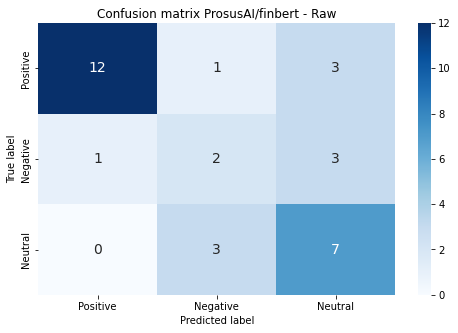

In [76]:
import seaborn as sns
df_cm = pd.DataFrame(cm, columns=["Positive", "Negative", "Neutral"], index=["Positive", "Negative", "Neutral"])
df_cm.index.name = "True label"
df_cm.columns.name = "Predicted label"
plt.figure(figsize=(8, 5))
plt.title(f"Confusion matrix {model_name} - Raw")
plot = sns.heatmap(
    df_cm, cmap="Blues", annot=True, annot_kws={"size": 14}
)  # font size

In [77]:
wandb.log({"seaborn cm": wandb.Image(plot)})

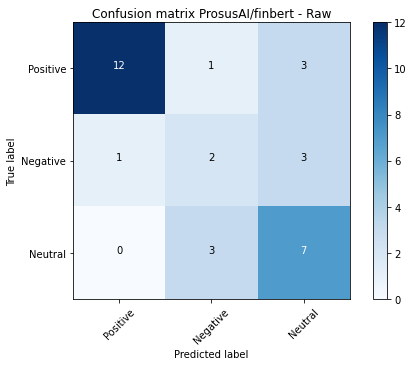

In [64]:
confusion_matrix_raw = plot_confusion_matrix_test(cm, target_names=["Positive", "Negative", "Neutral"], normalize=False, title=f"Confusion matrix {model_name} - Raw")

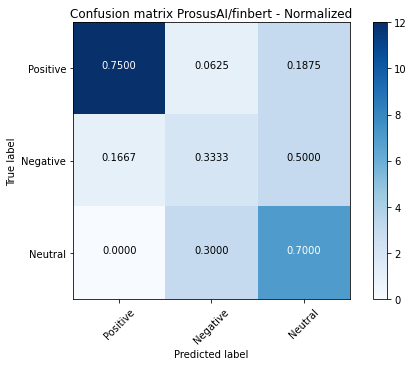

In [65]:
confusion_matrix_normalized = plot_confusion_matrix_test(cm, target_names=["Positive", "Negative", "Neutral"], normalize=True, title=f"Confusion matrix {model_name} - Normalized")

In [74]:
# Log confusion matrices to wandb
wandb.log({"Confusion matrix - Rawasdf": wandb.Image(confusion_matrix_raw), "Confusion matrix - Normalizedasdf": wandb.Image(confusion_matrix_normalized)})

In [63]:
def plot_confusion_matrix_test(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig = plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return fig

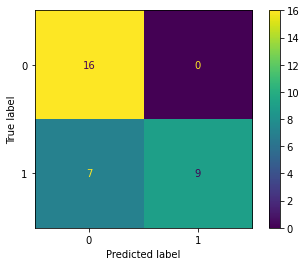

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot confusion matrix
mlcf = multilabel_confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(mlcf[0])
disp.plot()
plt.show()

In [66]:
mlcf

array([[[16,  0],
        [ 7,  9]],

       [[22,  4],
        [ 3,  3]],

       [[13,  9],
        [ 3,  7]]], dtype=int64)

In [58]:
wandb.log({"cm": wandb.sklearn.plot_confusion_matrix(y_true, y_pred)})

ValueError: multilabel-indicator is not supported

In [78]:
wandb.finish()

F1-Score Avg,▁
F1-Score Negative,▁
F1-Score Neutral,▁
F1-Score Positive,▁
Precision Avg,▁
Precision Negative,▁
Precision Neutral,▁
Precision Positive,▁
Recall Avg,▁
Recall Negative,▁
Recall Neutral,▁


In [41]:
# Morgen wandb einbinden in trainingsloop
test = torch.argmax(targets, dim=1).cpu()

In [48]:
test[0].item()

1

In [39]:
torch.argmax(outputs.logits, dim=1)

tensor([1, 0, 2, 0, 1, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2,
        0, 2, 2, 1, 1, 0, 2, 2], device='cuda:0')

In [24]:
# reihenfolge der target klassen anpassen
hello = torch.tensor([True, True, False, False]) == torch.tensor([True, True, False, False])

In [29]:
a = torch.randn(4, 10)
len(a)

4

In [30]:
a

tensor([[-0.5565, -1.5836,  0.8182,  0.4739, -0.0851, -0.1401, -1.4465,  0.8476,
         -2.0555,  2.4302],
        [-1.0015, -0.5909, -0.1389, -0.3330,  1.6120,  0.5044, -0.3765,  0.7283,
         -0.2022,  0.7693],
        [-1.9069, -0.1070, -0.6572, -0.2814, -0.2730, -0.6626, -0.1795,  1.0822,
          0.2099, -1.9514],
        [ 0.3541, -0.8508,  0.3249,  0.2214,  2.0938, -1.8457,  2.4814, -1.2087,
          0.1469, -0.8712]])

In [35]:
loss = torch.nn.BCEWithLogitsLoss()
input = torch.FloatTensor([0,1,0])
print(input)
target = torch.FloatTensor([1,0,0])
print(target)
output = loss(input, target, dim=1)
print(output)

tensor([0., 1., 0.])
tensor([1., 0., 0.])


TypeError: forward() got an unexpected keyword argument 'dim'

## WANDB test

In [26]:
import wandb

wandb.init(project="test-project", entity="hda_sis")

wandb: Currently logged in as: jan_burger (hda_sis). Use `wandb login --relogin` to force relogin


In [27]:
wandb.config = {
    "learning_rate": 0.001,
    "epochs": 100,
    "batch_size": 128
}

In [29]:
wandb.log({"loss": 2.5})

In [15]:
from sklearn.metrics import precision_score
import numpy as np

y_true = np.array([[0,0,1,1], [0,1,0,1], [1,0,0,1]])
y_pred = np.array([[0,1,0,1], [0,1,0,1], [1,0,0,1]])

In [16]:
precision_score(y_true=y_true, y_pred=y_pred, average=None)

C:\Users\janbu\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([1. , 0.5, 0. , 1. ])